In [5]:
import pandas as pd
from sklearn.cross_decomposition import CCA
import numpy as np
import matplotlib.pyplot as plt

subnums = np.arange(32, 98, 1)
subject_numbers = np.delete(subnums, np.where((subnums == 37) | (subnums == 66) | (subnums == 68) | (subnums == 78) | (subnums == 84) | (subnums == 90) | (subnums == 94) | (subnums == 96)))
print(len(subject_numbers))

# List to store the canonical weights for each electrode across subjects
electrode_weights = {elec: [] for elec in ['AFz', 'AF3', 'AF4', 'Fz', 'F1', 'F2', 'F3', 'F4', 'FC3', 'FC1', 'FC2', 'FC4', 'Cz', 'C3', 'C1', 'C2', 'C4']}
subject_correlation = []
subject_shifts = []
optimal_pupil_weights = []  # Store only the pupil weight at the optimal shift for each subject

for i in subject_numbers:
    # Load the EEG data
    eeg_filename = f"Theta_Processed/theta_results_subject_0{i}.csv"
    eeg_data = pd.read_csv(eeg_filename)

    # Load the pupil data
    pupil_filename = f"Pupil_Processed/pupil_memory_sub-0{i}.csv"
    pupil_data = pd.read_csv(pupil_filename)

    # Extract the memory power columns from the EEG data
    electrodes = list(electrode_weights.keys())
    memory_cols = [f'Theta_Power_Memory_{elec}' for elec in electrodes]
    eeg_memory_data = eeg_data[memory_cols]

    # Downsample the EEG data from 1000 Hz to 100 Hz by averaging every 10 rows
    eeg_memory_data_downsampled = eeg_memory_data.groupby(np.arange(len(eeg_memory_data)) // 10).mean().reset_index(drop=True)

    # Normalize the pupil data and EEG data
    pupil_diameter = (pupil_data['Mean_Diameter'] - pupil_data['Mean_Diameter'].mean()) / pupil_data['Mean_Diameter'].std()
    for col in memory_cols:
        eeg_memory_data_downsampled[col] = (eeg_memory_data_downsampled[col] - eeg_memory_data_downsampled[col].mean()) / eeg_memory_data_downsampled[col].std()

    # Ensure both datasets have the same number of rows
    min_len = min(len(eeg_memory_data_downsampled), len(pupil_diameter))
    eeg_memory_data_downsampled = eeg_memory_data_downsampled.iloc[:min_len]
    pupil_diameter = pupil_diameter.iloc[:min_len]

    # Define temporal shifts in the range of -1 second to 1 second (100 ms steps)
    shifts = np.arange(100, -101, -1)  # Shifts from -1 second to +1 second in 10ms increments

    # Initialize list to store correlations and weights for each shift
    shift_correlations = []
    shift_weights = []

    # Loop through each temporal shift and compute CCA
    for shift in shifts:
        # Shift EEG data and get the standard data window from index 200 to 1100
        eeg_memory_data_shifted = eeg_memory_data_downsampled.apply(lambda x: np.roll(x, shift)).iloc[200:1100]
        pupil_diameter_standardized = pupil_diameter.iloc[200:1100]  # Pupil diameter stays fixed

        # Perform Canonical Correlation Analysis (CCA)
        cca = CCA(n_components=1)  # One canonical component
        cca.fit(eeg_memory_data_shifted, pupil_diameter_standardized)

        # Get canonical weights for EEG and pupil data
        canonical_weights_eeg = cca.x_weights_.flatten()
        canonical_weights_pupil = cca.y_weights_.flatten()

        # Compute the product of linear weights with their respective original vectors
        combined_eeg = eeg_memory_data_shifted @ canonical_weights_eeg
        combined_pupil = pupil_diameter_standardized * canonical_weights_pupil  # Since pupil has 1D, just multiply

        # Calculate Pearson correlation between the combined EEG and pupil data
        pearson_corr = np.corrcoef(combined_eeg, combined_pupil)[0, 1]
        shift_correlations.append(pearson_corr)
        shift_weights.append((canonical_weights_eeg, canonical_weights_pupil))  # Store both EEG and pupil weights

    # Find the best shift and correlation
    best_shift_idx = np.argmax(shift_correlations)
    best_shift = -shifts[best_shift_idx] * 10
    best_correlation = shift_correlations[best_shift_idx]

    # Store weights only for the best shift
    best_weights_eeg, best_weights_pupil = shift_weights[best_shift_idx]
    for idx, elec in enumerate(electrodes):
        electrode_weights[elec].append(best_weights_eeg[idx])  # Append weights only for the best shift

    subject_correlation.append(best_correlation)
    subject_shifts.append(best_shift)

    # Store only the canonical weight for the pupil component at the optimal shift
    optimal_pupil_weights.append(best_weights_pupil[0])  # Since y_weights_ has only 1 component, take the single value

# Calculate and print the average weights and SEM for each electrode across subjects
average_weights = {elec: np.mean(weights) for elec, weights in electrode_weights.items()}
sem_weights = {elec: np.std(weights) / np.sqrt(len(weights)) for elec, weights in electrode_weights.items()}

# Sort the average weights by the absolute value in descending order
sorted_average_weights = sorted(average_weights.items(), key=lambda item: abs(item[1]), reverse=True)

print("Average Weights and SEM for each Electrode across Subjects:")
for elec, weight in sorted_average_weights:
    sem = sem_weights[elec]
    print(f"{elec} {weight:.3f} {sem:.3f}")

# Print the average and SEM for pupil weights at the optimal shift
print("\nAverage canonical weight on the pupil at the optimal shift across subjects:")
print(f"{np.mean(optimal_pupil_weights):.3f} ± {np.std(optimal_pupil_weights) / np.sqrt(len(optimal_pupil_weights)):.3f}")

print("\nAverage best correlation found:")
print(np.mean(subject_correlation))
print(np.std(subject_correlation) / np.sqrt(len(subject_correlation)))

print("\nAverage best temporal shift found:")
print(np.mean(subject_shifts))
print(np.std(subject_shifts) / np.sqrt(len(subject_shifts)))


58
Average Weights and SEM for each Electrode across Subjects:
AFz 0.154 0.058
AF3 -0.085 0.045
F1 0.051 0.034
AF4 -0.046 0.045
Fz -0.037 0.028
C4 -0.037 0.018
FC3 0.024 0.019
C3 -0.020 0.017
FC4 0.018 0.018
C2 0.017 0.025
FC1 -0.015 0.023
Cz -0.014 0.029
F3 -0.011 0.026
C1 0.010 0.026
F4 0.008 0.031
FC2 0.006 0.022
F2 -0.005 0.033

Average canonical weight on the pupil at the optimal shift across subjects:
-0.034 ± 0.131

Average best correlation found:
0.8276332402520823
0.00777238215629011

Average best temporal shift found:
-25.17241379310345
84.14508215063645


In [21]:
import pandas as pd
from sklearn.cross_decomposition import CCA
import numpy as np
import matplotlib.pyplot as plt

subnums = np.arange(32, 98, 1)
subject_numbers = np.delete(subnums, np.where((subnums == 37) | (subnums == 66) | (subnums == 68) | (subnums == 78) | (subnums == 84) | (subnums == 90) | (subnums == 94) | (subnums == 96)))
print(len(subject_numbers))
# List to store the canonical weights for each electrode across subjects
electrode_weights = {elec: [] for elec in ['AFz', 'AF3', 'AF4', 'Fz', 'F1', 'F2', 'F3', 'F4', 'FC3', 'FC1', 'FC2', 'FC4', 'Cz', 'C3', 'C1', 'C2', 'C4']}
subject_correlation_control = []
subject_shifts_control = []

for i in subject_numbers:
    # Load the EEG data
    eeg_filename = f"Theta_Processed/theta_results_subject_0{i}.csv"
    eeg_data = pd.read_csv(eeg_filename)

    # Load the pupil data
    pupil_filename = f"Pupil_Processed/pupil_control_sub-0{i}.csv"
    pupil_data = pd.read_csv(pupil_filename)

    # Extract the memory power columns from the EEG data
    electrodes = list(electrode_weights.keys())
    memory_cols = [f'Theta_Power_Control_{elec}' for elec in electrodes]
    eeg_memory_data = eeg_data[memory_cols]

    # Downsample the EEG data from 1000 Hz to 100 Hz by averaging every 10 rows
    eeg_memory_data_downsampled = eeg_memory_data.groupby(np.arange(len(eeg_memory_data)) // 10).mean().reset_index(drop=True)

    # Normalize the pupil data and EEG data
    pupil_diameter = (pupil_data['Mean_Diameter'] - pupil_data['Mean_Diameter'].mean()) / pupil_data['Mean_Diameter'].std()
    for col in memory_cols:
        eeg_memory_data_downsampled[col] = (eeg_memory_data_downsampled[col] - eeg_memory_data_downsampled[col].mean()) / eeg_memory_data_downsampled[col].std()

    # Ensure both datasets have the same number of rows
    min_len = min(len(eeg_memory_data_downsampled), len(pupil_diameter))
    eeg_memory_data_downsampled = eeg_memory_data_downsampled.iloc[:min_len]
    pupil_diameter = pupil_diameter.iloc[:min_len]

    # Define temporal shifts in the range of -1 second to 1 second (100 ms steps)
    shifts = np.arange(100, -101, -1)  # Shifts from -1 second to +1 second in 10ms increments

    # Initialize list to store correlations and weights for each shift
    shift_correlations = []
    shift_weights = []

    # Loop through each temporal shift and compute CCA
    for shift in shifts:
        print(shift)
        # Shift EEG data and get the standard data window from index 200 to 1100
        eeg_memory_data_shifted1 = eeg_memory_data_downsampled.apply(lambda x: np.roll(x, shift))
        eeg_memory_data_shifted = eeg_memory_data_shifted1[200:1100]
        pupil_diameter_standardized = pupil_diameter[200:1100]  # Pupil diameter stays fixed

        # Perform Canonical Correlation Analysis (CCA)
        cca = CCA(n_components=1)  # One canonical component
        cca.fit(eeg_memory_data_shifted, pupil_diameter_standardized)

        # Get canonical weights for EEG and pupil data
        canonical_weights_eeg = cca.x_weights_.flatten()
        canonical_weights_pupil = cca.y_weights_.flatten()

        # if canonical_weights_pupil < 0:
        #     canonical_weights_eeg *= -1
        #     canonical_weights_pupil = 1

        # Compute the product of linear weights with their respective original vectors
        combined_eeg = eeg_memory_data_shifted @ canonical_weights_eeg
        combined_pupil = pupil_diameter_standardized * canonical_weights_pupil  # Since pupil has 1D, just multiply

        canonical_weights_eeg = canonical_weights_eeg / np.linalg.norm(canonical_weights_eeg)

        # Calculate Pearson correlation between the combined EEG and pupil data
        pearson_corr = np.corrcoef(combined_eeg, combined_pupil)[0, 1]
        shift_correlations.append(pearson_corr)
        shift_weights.append(canonical_weights_eeg)  # Store weights for this shift

    # Find the best shift and correlation
    best_shift_idx = np.argmax(shift_correlations)
    best_shift = -shifts[best_shift_idx] * 10
    best_correlation = shift_correlations[best_shift_idx]

    # Store weights only for the best shift
    best_weights = shift_weights[best_shift_idx]
    for idx, elec in enumerate(electrodes):
        electrode_weights[elec].append(best_weights[idx])  # Append weights only for the best shift

    subject_correlation_control.append(best_correlation)
    subject_shifts_control.append(best_shift)

# Calculate and print the average weights and SEM for each electrode across subjects
average_weights = {elec: np.mean(weights) for elec, weights in electrode_weights.items()}
sem_weights = {elec: np.std(weights) / np.sqrt(len(weights)) for elec, weights in electrode_weights.items()}

# Sort the average weights by the absolute value in descending order
sorted_average_weights_control = sorted(average_weights.items(), key=lambda item: abs(item[1]), reverse=True)

print("Average Weights and SEM for each Electrode across Subjects:")
for elec, weight in sorted_average_weights_control:
    sem = sem_weights[elec]
    print(f"{elec} {weight:.3f} {sem:.3f}")

print("\nAverage best correlation found:")
print(np.mean(subject_correlation_control))
print(np.std(subject_correlation_control) / np.sqrt(len(subject_correlation_control)))

print("\nAverage best temporal shift found:")
print(np.mean(subject_shifts_control))
print(np.std(subject_shifts_control) / np.sqrt(len(subject_shifts_control)))


58
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
-1
-2
-3
-4
-5
-6
-7
-8
-9
-10
-11
-12
-13
-14
-15
-16
-17
-18
-19
-20
-21
-22
-23
-24
-25
-26
-27
-28
-29
-30
-31
-32
-33
-34
-35
-36
-37
-38
-39
-40
-41
-42
-43
-44
-45
-46
-47
-48
-49
-50
-51
-52
-53
-54
-55
-56
-57
-58
-59
-60
-61
-62
-63
-64
-65
-66
-67
-68
-69
-70
-71
-72
-73
-74
-75
-76
-77
-78
-79
-80
-81
-82
-83
-84
-85
-86
-87
-88
-89
-90
-91
-92
-93
-94
-95
-96
-97
-98
-99
-100
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
-1
-2
-3
-4
-5
-6

58 58


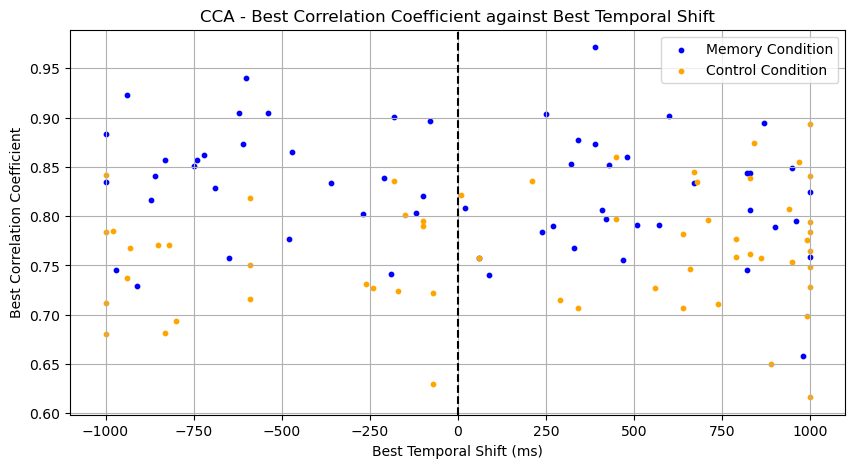

0.971285340010964 -390


In [24]:
# Extract best correlations and best temporal shifts for the AFz electrode
best_correlations_AFz = subject_correlation
best_temporal_shifts_AFz = -np.array(subject_shifts)

best_correlations_AFz_control = subject_correlation_control
best_temporal_shifts_AFz_control = -np.array(subject_shifts_control)

print(len(subject_correlation), len(subject_correlation_control))

# Plot the best correlations against the best temporal shifts for AFz electrode
plt.figure(figsize=(10, 5))
plt.scatter(best_temporal_shifts_AFz, best_correlations_AFz, marker='o', s=10, color='b', label='Memory Condition')
plt.scatter(best_temporal_shifts_AFz_control, best_correlations_AFz_control, marker='o', s=10, color='orange', label='Control Condition')
# plt.xticks(np.arange(-1000, 1001, 250))
# plt.yticks(np.arange(0.60, 1.01, 0.05))
plt.xlabel('Best Temporal Shift (ms)')
plt.ylabel('Best Correlation Coefficient')
plt.title('CCA - Best Correlation Coefficient against Best Temporal Shift')
plt.grid(True)
plt.axvline(0, color='k', linestyle='--')  # Optional: vertical line at x=0 for reference
plt.legend()
plt.show()

print(max(subject_correlation), subject_shifts[np.argmax(subject_correlation)])
